# This is my data project
## this is smaller title
### this is even smaller
this is text

# Data Audit
Why was it collected?: Netflix
Who paid for it?: Netflix
Where did you get it from?: Netflix

`imports`, I've seen this before!

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime

Some magic that tells jupyter to put graphs and things in the notebook instead of the default behaviour which is to save it as a file.

In [ ]:
%matplotlib inline

Set the size of the plots that will come out when we ask for them. Annoyingly, these are in inches. Whatever an "inch" is

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)


In [ ]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to


The following checks to see if we've already downloaded the data. It's a big file, so we don't want to do it every time we run the code. Even just loading from file takes a few seconds!

Pandas is pretty smart, it can get data from the internet just as easily as from the file system, it just takes a bit longer.

In [ ]:
if os.path.isfile("all-weeks-countries.csv"):
    filepath = "all-weeks-countries.csv"
    print("loading from file")
else:
    filepath = "https://www.kaggle.com/datasets/dhruvildave/netflix-top-10-tv-shows-and-films?resource=download&select=all-weeks-countries.csv"
    print("loading from the internet")

netflix_data = pd.read_csv(filepath)
print("done")


loading from file
done


In [ ]:
netflix_data.head() #gives the top 5 rows

,country_name,country_iso2,week,category,weekly_rank,show_title,season_title,cumulative_weeks_in_top_10
0,Argentina,AR,2022-08-21,Films,1,Look Both Ways,NaN,1
1,Argentina,AR,2022-08-21,Films,2,Day Shift,NaN,2
2,Argentina,AR,2022-08-21,Films,3,Bank Robbers: The Last Great Heist,NaN,2
3,Argentina,AR,2022-08-21,Films,4,The Next 365 Days,NaN,1
4,Argentina,AR,2022-08-21,Films,5,The Angry Birds Movie 2,NaN,1


In [ ]:
count_of_shows=netflix_data["show_title"].value_counts()
count_of_shows

show_title
Stranger Things                           3119
The Good Doctor                           1759
Money Heist                               1642
Manifest                                  1482
Squid Game                                1202
                                          ... 
Zero Dark Thirty                             1
Son of the Mask                              1
Oprah + Viola: A Netflix Special Event       1
No Good Deed                                 1
Glitch                                       1
Name: count, Length: 3459, dtype: int64

<Axes: xlabel='show_title'>

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49800 (\N{HANGUL SYLLABLE SYU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47112 

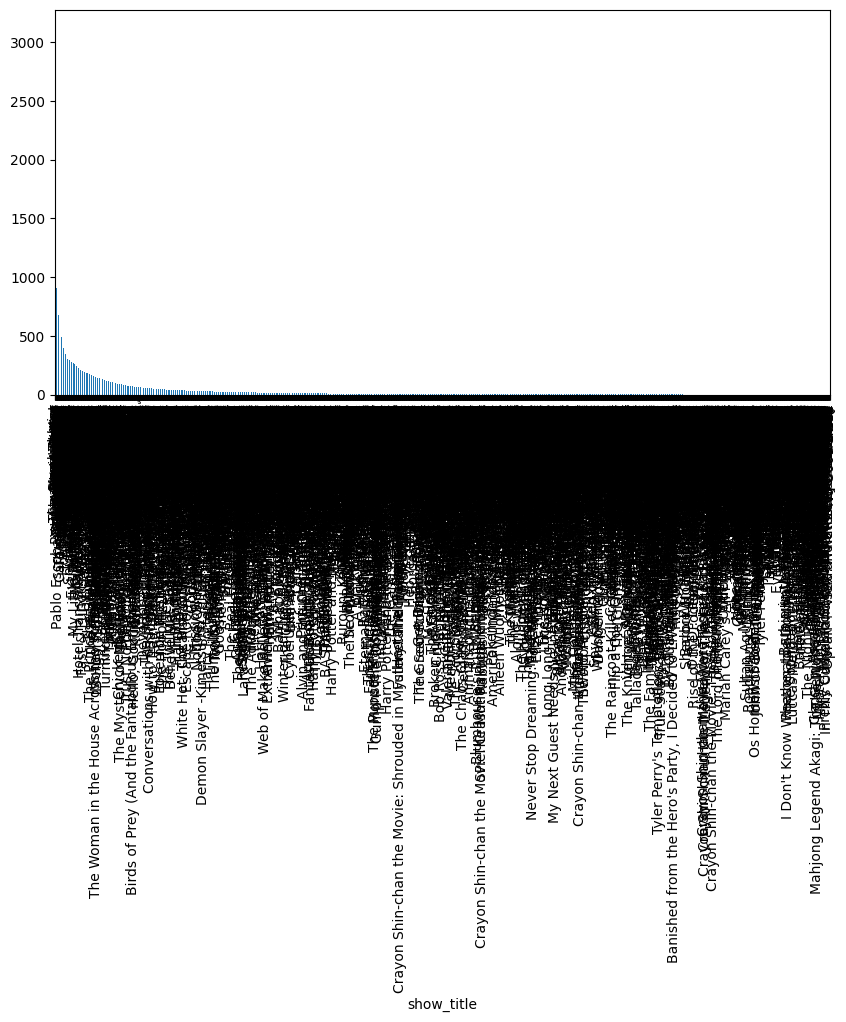

In [ ]:
count_of_shows.plot(kind="bar")

the below only plots the tv shows that show up less than a specific number of times

<Axes: ylabel='show_title'>

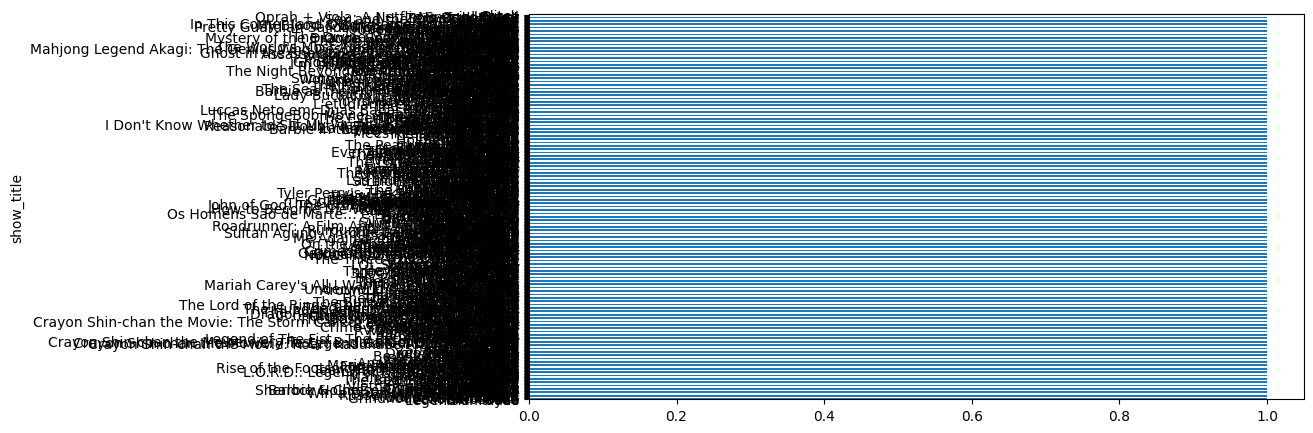

In [ ]:
count_of_shows[count_of_shows ==1].plot(kind="barh")

<BarContainer object of 656 artists>

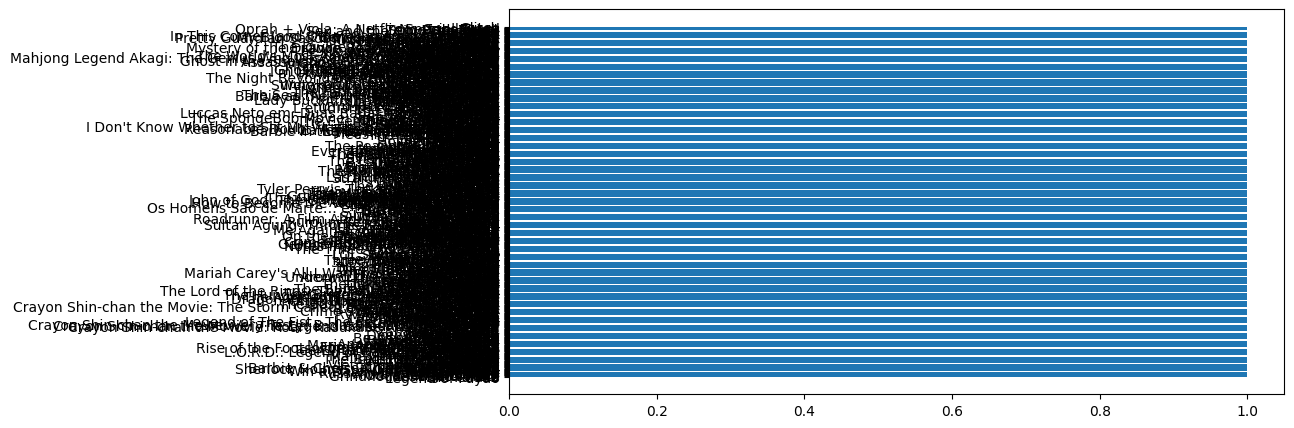

In [ ]:
plt.barh(count_of_shows[count_of_shows==1].index,count_of_shows[count_of_shows==1].values)

In [ ]:
netflix_data = pd.read_csv(
    filepath,
    infer_datetime_format=True,
    parse_dates=["week"],
)
netflix_data.head(2)


/var/folders/m6/9l2c43w54_dcl4z2zjrmxh940000gn/T/ipykernel_19826/3425564230.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  netflix_data = pd.read_csv(


,country_name,country_iso2,week,category,weekly_rank,show_title,season_title,cumulative_weeks_in_top_10
0,Argentina,AR,2022-08-21,Films,1,Look Both Ways,NaN,1
1,Argentina,AR,2022-08-21,Films,2,Day Shift,NaN,2


In [ ]:
first_date = netflix_data.week.min()
last_date = netflix_data.week.max()
f"range is: {first_date} to {last_date}"


'range is: 2021-07-04 00:00:00 to 2022-08-21 00:00:00'

In [ ]:
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(first_date, date_format_pattern)
latest_date = datetime.strftime(last_date, date_format_pattern)
f"range is: {earliest_date} to {latest_date}"

'range is: July, 2021 to August, 2022'

In [ ]:
filtered_data = netflix_data[(netflix_data['week'] >= '2021-07-01')|(netflix_data['week'] <= '2021-07-07')|(netflix_data['country_name']==Malaysia)]
show_counts = filtered_data['show_title'].value_counts()
plt.barh(show_counts.index, show_counts.values, color='skyblue')